Deep Dream Implementation 

In [79]:
!pip install tensorflow-gpu==2.0.0.alpha0

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

1) Import the model

In [81]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_282 (Bat (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_v1_282[0][0] 
_______________________________________________________________________________________

In [0]:
# Take the concatenated layers from inception
names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']

# Get the layers output
layers = [base_model.get_layer(name).output for name in names]

# Model definition with functional API
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


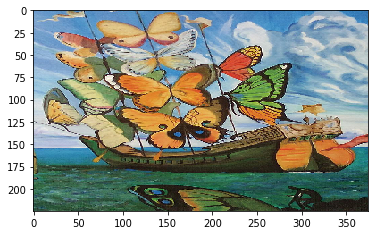

In [83]:
from google.colab import drive
drive.mount('/content/drive')

sample_image = tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/salvador_dali.jpg', 
    target_size = (225, 375))

plt.imshow(sample_image)

In [84]:
sample_image = np.array(sample_image)/255
sample_image.shape

(225, 375, 3)

2) Run the model

In [85]:
sample_array = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_array.shape


(225, 375, 3)

In [86]:
sample_variable = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_array))
sample_variable = tf.expand_dims(sample_variable, axis = 0)
np.shape(sample_variable)

TensorShape([1, 225, 375, 3])

In [0]:
# Visualize the activation layers
activations = deepdream_model(sample_variable)

3) Network loss calculation

In [0]:
def calc_loss(image, model):
  
  # Expand dimension of the image
  img_batch = tf.expand_dims(image, axis=0)

  # Run the model  
  layer_activations = model(img_batch)

  # Calculate the losses
  losses = []

  for act in layer_activations:
    loss = tf.math.reduce_mean(act) # calculate mean of each activation 
    losses.append(loss)
  
  print('LOSSES (FROM MULTIPLE ACTIVATION LAYERS) = ', losses)
  print('LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) = ', np.shape(losses))
  print('SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)= ', tf.reduce_sum(losses))
  
  # Calculate sum
  return  tf.reduce_sum(losses)  



In [89]:
sample_image = tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/salvador_dali.jpg', 
    target_size = (225, 375))

sample_image = np.array(sample_image)/255

sample_array = tf.keras.preprocessing.image.img_to_array(sample_image)

sample_variable = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_array))

# Sum of 4 loss of the previous selected layers
overall_loss = calc_loss(sample_variable, deepdream_model)

LOSSES (FROM MULTIPLE ACTIVATION LAYERS) =  [<tf.Tensor: id=53548, shape=(), dtype=float32, numpy=0.2716141>, <tf.Tensor: id=53550, shape=(), dtype=float32, numpy=0.16908206>, <tf.Tensor: id=53552, shape=(), dtype=float32, numpy=0.1452868>, <tf.Tensor: id=53554, shape=(), dtype=float32, numpy=0.051277302>]
LOSSES SHAPE (FROM MULTIPLE ACTIVATION LAYERS) =  (4,)
SUM OF ALL LOSSES (FROM ALL SELECTED LAYERS)=  tf.Tensor(0.6372603, shape=(), dtype=float32)


4) Gradient calculation from the previous losses

In [0]:
@tf.function
def deepdream(model, image, step_size):
    # Track the specific gradients
    with tf.GradientTape() as tape:
      tape.watch(image)

      # Calculate the loss of the glayers
      loss = calc_loss(image, model) 

    # Gradient calculation
    gradients = tape.gradient(loss, image)

    print('GRADIENTS =\n', gradients)
    print('GRADIENTS SHAPE =\n', np.shape(gradients))

    # Standard deviation of all the gradients
    gradients /= tf.math.reduce_std(gradients)  

    # Add the gradients to the image and clip the values
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)

    return loss, image

In [0]:
def process(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)

In [0]:

def run_deep_dream(model, image, steps = 100, step_size = 0.01):

  # Preprocess input
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  # Calculate for different step sizes
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)

    # Print figures
    if step % 100 == 0:
      plt.figure(figsize = (12, 12))
      plt.imshow(process(image))
      plt.show()
      print ("Step {}, loss {}".format(step, loss))

  plt.figure(figsize=(12,12))
  plt.imshow(process(image))
  plt.show()

  return process(image)


5) Check the results

In [132]:

sample_image= tf.keras.preprocessing.image.load_img(
    r'/content/drive/My Drive/Colab Notebooks/IMG_0199.jpg', 
    target_size = (375, 225))

sample_image = np.array(sample_image)

dream_img = run_deep_dream(model = deepdream_model, 
                           image = sample_image, 
                           steps = 2000,
                           step_size = 0.001)


Output hidden; open in https://colab.research.google.com to view.